<a href="https://colab.research.google.com/github/talhaanwarch/skin_lesion_diagnosis_app/blob/master/pytorch_densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip

--2020-07-15 16:39:45--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.40.160
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.40.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3593344681 (3.3G) [application/octet-stream]
Saving to: ‘zr7vgbcyr2-1.zip’

zr7vgbcyr2-1.zip    100%[===================>]   3.35G  24.7MB/s    in 60s     

2020-07-15 16:40:46 (57.2 MB/s) - ‘zr7vgbcyr2-1.zip’ saved [3593344681/3593344681]



In [2]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=dd350892b130ca2d10da5f971380454ae3dbbacfa8fa83324b16e4612d4e7aa6
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [3]:
%%capture
!unzip zr7vgbcyr2-1.zip

In [4]:
!mkdir data

In [5]:
%%capture
!unzip /content/images/imgs_part_1.zip
!unzip /content/images/imgs_part_2.zip
!unzip /content/images/imgs_part_3.zip


In [6]:
!mv  /content/imgs_part_1/* /content/data
!mv  /content/imgs_part_2/* /content/data
!mv  /content/imgs_part_3/* /content/data


In [7]:
!rm -r /content/images

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv('/content/metadata.csv')
df.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARM,NaN,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACE,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAND,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True


In [9]:
import random
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import PIL

In [10]:
print(torch.__version__)
print(torchvision.__version__)
print(PIL.__version__)

1.5.1+cu101
0.6.1+cu101
7.0.0


In [11]:
img_id=df['img_id']
img_label=df['diagnostic']

In [12]:
cls=img_label.value_counts()
cls_len=len(cls)
cls

BCC    845
ACK    730
NEV    244
SEK    235
SCC    192
MEL     52
Name: diagnostic, dtype: int64

In [13]:
img_id.head()

0    PAT_1516_1765_530.png
1       PAT_46_881_939.png
2    PAT_1545_1867_547.png
3    PAT_1989_4061_934.png
4     PAT_684_1302_588.png
Name: img_id, dtype: object

In [14]:
img_id='/content/data/'+img_id

In [15]:
img_id.head()

0    /content/data/PAT_1516_1765_530.png
1       /content/data/PAT_46_881_939.png
2    /content/data/PAT_1545_1867_547.png
3    /content/data/PAT_1989_4061_934.png
4     /content/data/PAT_684_1302_588.png
Name: img_id, dtype: object

In [16]:
print(len(img_id))
print(len(img_label))

2298
2298


In [17]:
img_label=img_label.map({'BCC':0,'ACK':1,'NEV':2,'SEK':3,'SCC':4,'MEL':5})

In [18]:
# from sklearn.preprocessing import OneHotEncoder,LabelEncoder
# # enc=OneHotEncoder(sparse=False,dtype=np.int)
# # img_label=enc.fit_transform(img_label.values.reshape(-1,1))
# enc=LabelEncoder()
# img_label=enc.fit_transform(img_label)

In [19]:
img_label[0:5]

0    2
1    0
2    1
3    1
4    0
Name: diagnostic, dtype: int64

In [20]:
class dfloader(torch.utils.data.Dataset):
    
    def __init__(self,img_id,img_label,transform=None):
        self.img_id = img_id    
        self.img_label=img_label
        self.transform=transform
        
    def __getitem__(self,index):
        if type(index) == torch.Tensor:
          index = index.item()
        img_ind=self.img_id[index]
        label_ind=self.img_label[index]

        img = Image.open(img_ind).convert('RGB')
      
        if self.transform:
           img=self.transform(img) 
  
        return img ,label_ind
    
    def __len__(self):
        return len(self.img_id)

In [21]:
from torchvision import transforms 
aug=transforms.Compose([
                        transforms.Resize((224,224)),
                        #transforms.CenterCrop(10),
                        transforms.RandomAffine(degrees=0, translate=None, scale=(1,1.5), shear=None, resample=Image.NEAREST, fillcolor=0),
                        transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomRotation(360),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5820, 0.4512, 0.4023], [0.2217, 0.1858, 0.1705]),

                        ])


data=dfloader(img_id,img_label,transform=aug)

In [22]:
len(data)

2298

In [23]:
from torch.utils.data import random_split
train_dataset,val_dataset,test_dataset=random_split(data, lengths=
                                       [int(np.floor(len(data)*0.75)),int(np.ceil(len(data)*0.15)),int(np.ceil(len(data)*0.10))])
print('no of images in train dataset is ',len(train_dataset), 
      'val dataset is',len(val_dataset),
      'and test dataset is',len(test_dataset))

no of images in train dataset is  1723 val dataset is 345 and test dataset is 230


In [24]:
from torch.utils.data.dataloader import DataLoader
train_loader = DataLoader(train_dataset,shuffle=True,num_workers=0,batch_size=32)
val_loader = DataLoader(val_dataset,shuffle=True,num_workers=0,batch_size=32)
test_loader = DataLoader(test_dataset,shuffle=False,num_workers=0,batch_size=len(test_dataset))


In [25]:
example_batch = iter(train_loader)
example_batch = next(example_batch)

In [26]:
example_batch[0].shape,example_batch[1].shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


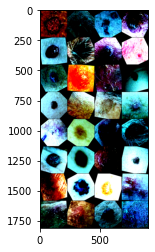

In [27]:

plt.imshow(torchvision.utils.make_grid(example_batch[0],nrow=4).permute(1, 2, 0))

In [28]:
example_batch[1]

tensor([1, 1, 3, 4, 0, 3, 3, 0, 0, 0, 0, 2, 2, 1, 1, 0, 1, 2, 0, 3, 3, 2, 2, 3,
        4, 5, 0, 0, 1, 0, 2, 1])

In [29]:
# mean = 0.
# std = 0.
# nb_samples = 0.
# for data,_ in train_loader:
#     batch_samples = data.size(0)
#     data = data.view(batch_samples, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples
# mean,std

# efficient model

https://kobiso.github.io/Computer-Vision-Leaderboard/imagenet.html

In [30]:
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=cls_len)

In [31]:
# #https://github.com/lukemelas/EfficientNet-PyTorch/issues/207
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b3')
# model._fc = nn.Sequential(nn.Linear(model._fc.in_features, 512), 
#                                            nn.ReLU(),  
#                                            nn.Dropout(0.25),
#                                            nn.Linear(512, 128), 
#                                            nn.ReLU(),  
#                                            nn.Dropout(0.20), 
#                                            nn.Linear(128,cls_len))

In [32]:
# import torchvision.models as models
# import torch.nn as nn
# model = models.resnet18(pretrained=True)
# #model.fc = torch.nn.Linear(512, cls_len)
# model.fc=nn.Sequential(
#                       nn.Linear(512, 256), 
#                       nn.ReLU(), 
#                       nn.Dropout(0.4),
#                       nn.Linear(256, cls_len),                   
#                       nn.LogSoftmax(dim=1))
# #model.classifier[1] = torch.nn.Linear(model.last_channel, cls_len)

# # #https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [33]:
import torchvision.models as models
import torch.nn as nn
model=models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
                      nn.Linear(num_ftrs, 256), 
                      nn.ReLU(), 

                      nn.Linear(256, cls_len),                   
                      nn.LogSoftmax(dim=1))

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [34]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
Tesla K80


In [35]:
device=torch.device('cuda')

In [36]:
model=model.to(device)

In [37]:
nSamples = cls.tolist()
normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
print(normedWeights)
#normedWeights = torch.FloatTensor(normedWeights).to(device)

[0.6322889469103568, 0.6823324630113141, 0.8938207136640557, 0.8977371627502175, 0.9164490861618799, 0.9773716275021758]


In [38]:
weights=[0.5,0.7,0.9,0.9,0.95,0.99]
normedWeights = torch.FloatTensor(weights).to(device)

In [39]:
criterion=torch.nn.CrossEntropyLoss(weight=normedWeights)
opt=torch.optim.Adam(params=model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode ='min',factor=0.5, patience=3, verbose=True)

In [40]:
for train_batch in train_loader:
  train_img,train_label=train_batch
  print(train_img.shape,train_label.shape)
  break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [41]:
from time import time
train_loss_plt=[]
val_loss_plt=[]
train_acc_plt=[]
val_acc_plt=[]
for ep in range(20):
  start=time()
  #start training loop
  train_loss_sum=0
  train_acc_sum=0
  for train_batch in train_loader:
    train_img,train_label=train_batch
    train_img,train_label = train_img.to(device),train_label.to(device)

    train_out=model(train_img)
    train_loss=criterion(train_out,train_label)
    opt.zero_grad()
    train_loss.backward()
    opt.step()
    train_loss_sum+=train_loss.item()
    train_acc_sum += ((torch.max(train_out,dim=1)[1]==train_label).sum().item())/len(train_label)
  #start validation loop
  val_loss_sum=0
  val_acc_sum=0
  model.eval()
  with torch.no_grad():
    for val_image,val_label in val_loader:
      val_image,val_label=val_image.to(device),val_label.to(device)
      val_out=model(val_image)
      val_loss=criterion(val_out,val_label)
      val_loss_sum+=val_loss.item()
      val_acc_sum+=((torch.max(val_out,dim=1)[1]==val_label).sum().item())/len(val_label)
  end=np.round((time()-start)/60,2) #time in minute
  model.train()
  #calculate print and append the results for plotting purpose
  val_avg_loss=np.round(val_loss_sum/len(val_loader),2)#val loss of all batches of one epoch
  train_avg_loss=np.round(train_loss_sum/len(train_loader),2)# train loss of all batches of one epoch
  train_avg_acc=np.round(train_acc_sum/len(train_loader),2)#train acc of all batches of one epoch
  val_avg_acc=np.round(val_acc_sum/len(val_loader),2)#val acc of all batches of one epoch
  scheduler.step(val_avg_loss)
  print('Epoch {}, time {} , train acc  {}, train loss {} , val acc is {}, loss is {}, learning rate is {} '.format
        (ep,end,train_avg_acc,train_avg_loss,val_avg_acc,val_avg_loss,opt.param_groups[0]['lr']))
  train_loss_plt.append(train_avg_loss)  #append loss of training data  
  val_loss_plt.append(val_avg_loss)     #append loss of validation data
  train_acc_plt.append(train_avg_acc)  #append acc of training data  
  val_acc_plt.append(val_avg_acc)     #append acc of validation data

Epoch 0, time 2.3 , train acc  0.49, train loss 1.4 , val acc is 0.42, loss is 3.63, learning rate is 0.001 
Epoch 1, time 2.29 , train acc  0.58, train loss 1.22 , val acc is 0.64, loss is 1.06, learning rate is 0.001 
Epoch 2, time 2.28 , train acc  0.61, train loss 1.12 , val acc is 0.56, loss is 1.25, learning rate is 0.001 
Epoch 3, time 2.28 , train acc  0.63, train loss 1.05 , val acc is 0.64, loss is 1.01, learning rate is 0.001 
Epoch 4, time 2.28 , train acc  0.64, train loss 1.01 , val acc is 0.65, loss is 0.98, learning rate is 0.001 
Epoch 5, time 2.28 , train acc  0.65, train loss 1.01 , val acc is 0.66, loss is 0.91, learning rate is 0.001 
Epoch 6, time 2.28 , train acc  0.67, train loss 0.94 , val acc is 0.69, loss is 0.93, learning rate is 0.001 
Epoch 7, time 2.29 , train acc  0.7, train loss 0.92 , val acc is 0.69, loss is 0.89, learning rate is 0.001 
Epoch 8, time 2.27 , train acc  0.66, train loss 0.93 , val acc is 0.68, loss is 0.9, learning rate is 0.001 
Epoch

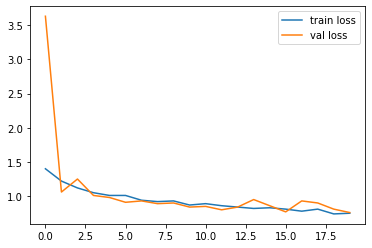

In [42]:
plt.plot(train_loss_plt,label='train loss')
plt.plot(val_loss_plt,label='val loss')
plt.legend()
plt.show()

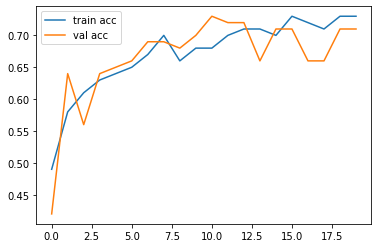

In [43]:
plt.plot(train_acc_plt,label='train acc')
plt.plot(val_acc_plt,label='val acc')
plt.legend()
plt.show()

In [44]:
torch.save(model, 'skin_model.pth')
#

In [45]:
model.eval()
with torch.no_grad():
  for img,grnd_label in test_loader:
    print(img.shape)
    test_pred=model(img.to(device))


torch.Size([230, 3, 224, 224])


In [46]:
test_pred.shape,grnd_label.shape

(torch.Size([230, 6]), torch.Size([230]))

In [47]:
y_pred=torch.max(test_pred,dim=1)

In [48]:
y_pred=y_pred[1].cpu().numpy()

In [49]:
grnd_label=grnd_label.numpy()

In [50]:
from sklearn.metrics import accuracy_score,f1_score
print(accuracy_score(grnd_label,y_pred))
print(f1_score(grnd_label,y_pred,average='macro'))

0.6956521739130435
0.6292655259665093


In [51]:
from sklearn.metrics import classification_report
print(classification_report(grnd_label,y_pred))


              precision    recall  f1-score   support

           0       0.75      0.80      0.77        88
           1       0.69      0.75      0.72        64
           2       0.73      0.70      0.72        27
           3       0.53      0.68      0.60        25
           4       0.50      0.14      0.22        21
           5       1.00      0.60      0.75         5

    accuracy                           0.70       230
   macro avg       0.70      0.61      0.63       230
weighted avg       0.69      0.70      0.68       230



In [52]:
# you can improve the result further. 

In [77]:
dis={0:'Basal Cell Carcinoma (BCC)',1:'Actinic Keratosis (ACK)',2:'Nevus (NEV)',
3:'Seborrheic Keratosis (SEK)',4:'Squamous Cell Carcinoma (SCC)	',5:'Melanoma (MEL)'}

In [78]:
img = Image.open('/content/data/PAT_1545_1867_547.png')
img=img.convert(mode='RGB')
image = aug(img)
image=image.unsqueeze(0) #add another dimension at 0
out=model(image.cuda())
out=torch.mean(out,dim=0)
print(out)
out=out.detach().cpu().numpy()
out=np.argmax(out)
print(dis[out])

tensor([-0.5816, -1.8025, -2.7595, -3.9683, -1.7235, -4.1697], device='cuda:0',
       grad_fn=<MeanBackward1>)
Basal Cell Carcinoma (BCC)


In [61]:
model_cpu=torch.load('/content/skin_model.pth', map_location=lambda storage, loc: storage)

In [79]:
img = Image.open('/content/data/PAT_1545_1867_547.png')
img=img.convert(mode='RGB')
image = aug(img)
image=image.unsqueeze(0) #add another dimension at 0
model_cpu.eval()
out=model_cpu(image)
out=torch.mean(out,dim=0)
print(out)
out=out.detach().numpy()
out=np.argmax(out)
print(dis[out])

tensor([-0.7410, -1.5777, -3.7733, -3.6542, -1.4247, -3.5950],
       grad_fn=<MeanBackward1>)
Basal Cell Carcinoma (BCC)


In [76]:
img.save('ack.png')

In [60]:
img.show()

In [53]:
df.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARM,NaN,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACE,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAND,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True


In [67]:
model.eval()
with torch.no_grad():
  for img,grnd_label in test_loader:
    print(img.shape)
    test_pred=model_cpu(img)

torch.Size([230, 3, 224, 224])


In [69]:
test_pred.dtype

torch.float32

In [70]:
y_pred=torch.max(test_pred,dim=1)

In [71]:
y_pred=y_pred[1].cpu().numpy()
grnd_label=grnd_label.numpy()

In [72]:
from sklearn.metrics import classification_report
print(classification_report(grnd_label,y_pred))


              precision    recall  f1-score   support

           0       0.73      0.80      0.76        88
           1       0.66      0.73      0.70        64
           2       0.85      0.63      0.72        27
           3       0.59      0.68      0.63        25
           4       0.40      0.19      0.26        21
           5       0.50      0.40      0.44         5

    accuracy                           0.68       230
   macro avg       0.62      0.57      0.59       230
weighted avg       0.67      0.68      0.67       230

